In [23]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [24]:
# Dataset config
NUM_ENCODE_TIME_STEPS = 100
NUM_DECODE_TIME_STEPS = 5

In [25]:
temp = None

with open('temperature.csv', 'r') as f:
    reader = csv.reader(f)
    temp = list(reader)

In [26]:
# Process with Panda dataframe
temp_df = pd.DataFrame(temp[1:], columns=temp[0])

print("Original dataframe: ")
print(temp_df)

temp_df = temp_df.drop(columns=["Date"])
temp_df = temp_df.astype(float)
temp_df = temp_df.fillna(0) # Replace NaN with 0 (time where trade volume = 0)

print("Processed dataframe: ")
print(temp_df)

Original dataframe: 
            Date  Temp
0     1981-01-01  20.7
1     1981-01-02  17.9
2     1981-01-03  18.8
3     1981-01-04  14.6
4     1981-01-05  15.8
...          ...   ...
3645  1990-12-27  14.0
3646  1990-12-28  13.6
3647  1990-12-29  13.5
3648  1990-12-30  15.7
3649  1990-12-31  13.0

[3650 rows x 2 columns]
Processed dataframe: 
      Temp
0     20.7
1     17.9
2     18.8
3     14.6
4     15.8
...    ...
3645  14.0
3646  13.6
3647  13.5
3648  15.7
3649  13.0

[3650 rows x 1 columns]


In [27]:
# Convert to tensor
temp_tensor = torch.from_numpy(temp_df.values).squeeze(1) + 273 # In kelvin to avoid 0 degree
print(temp_tensor)

tensor([293.7000, 290.9000, 291.8000,  ..., 286.5000, 288.7000, 286.0000],
       dtype=torch.float64)


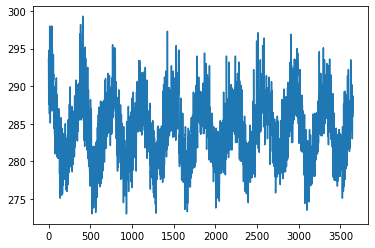

In [28]:
plt_time = list(range(len(temp_tensor)))
plt.plot(plt_time, temp_tensor, label="Temperature")

In [30]:
# Make input time serie data and target time serie data tensor 
X_shape = (temp_tensor.shape[0] - NUM_ENCODE_TIME_STEPS - NUM_DECODE_TIME_STEPS, NUM_ENCODE_TIME_STEPS)
y_shape = (temp_tensor.shape[0] - NUM_ENCODE_TIME_STEPS - NUM_DECODE_TIME_STEPS, NUM_DECODE_TIME_STEPS)



X = torch.empty(X_shape)
y = torch.empty(y_shape)

# Change from last time step (more numerically stable for the neural net)
for i in range(X.shape[0]):
    serie_end_i = i + NUM_ENCODE_TIME_STEPS + NUM_DECODE_TIME_STEPS
    time_serie = (temp_tensor[i+1:serie_end_i+1] - temp_tensor[i:serie_end_i]) / temp_tensor[i:serie_end_i]
    X[i] = time_serie[:NUM_ENCODE_TIME_STEPS]
    y[i] = time_serie[NUM_ENCODE_TIME_STEPS:]

# Change in percentage
X = X * 100
y = y * 100

print("Encode time serie data shape:", X_shape)
print("Decode time serie data shape:", y_shape)
print("Training X:\n", X)
print("Training y:\n", y)

Encode time serie data shape: (3545, 100)
Decode time serie data shape: (3545, 5)
Training X:
 tensor([[-0.9534,  0.3094, -1.4393,  ...,  0.3473, -1.0038, -1.8881],
        [ 0.3094, -1.4393,  0.4172,  ..., -1.0038, -1.8881,  1.3899],
        [-1.4393,  0.4172,  0.0000,  ..., -1.8881,  1.3899,  0.7030],
        ...,
        [ 0.1060, -2.3641,  1.3010,  ...,  0.0350,  0.2446, -1.3594],
        [-2.3641,  1.3010,  1.5341,  ...,  0.2446, -1.3594,  1.0247],
        [ 1.3010,  1.5341,  1.6514,  ..., -1.3594,  1.0247,  0.5946]])
Training y:
 tensor([[ 1.3899,  0.7030, -0.1745,  0.1049, -0.4191],
        [ 0.7030, -0.1745,  0.1049, -0.4191,  0.1052],
        [-0.1745,  0.1049, -0.4191,  0.1052,  0.2803],
        ...,
        [ 1.0247,  0.5946, -0.2086, -0.1394, -0.0349],
        [ 0.5946, -0.2086, -0.1394, -0.0349,  0.7679],
        [-0.2086, -0.1394, -0.0349,  0.7679, -0.9352]])


In [32]:
print(X.shape)
print("Average absolute change:", torch.mean(torch.absolute(X)))
print("Maximum change:", torch.max(y))
print("Minimum change:", torch.min(y))

torch.Size([3545, 100])
Average absolute change: tensor(0.7499)
Maximum change: tensor(3.3727)
Minimum change: tensor(-4.2718)


In [33]:
# Checking for nan data
assert(torch.sum(X != X) == 0)
assert(torch.sum(y != y) == 0)

In [34]:
torch.save(X, "./../X.pt")
torch.save(y, "./../y.pt")